## Definitions
Code for Histopathology classification challenge.

Autors: Patricia Cabanillas & Zohaib Salahuddin


```
# Tiene formato de código
```



In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
import random
%matplotlib inline
!pip install barbar 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading and Unzipping the data

In [0]:
file_id_train = "1Ftj263G6uN4RoC4i3dUpB9CgHWYMsZn1"
file_id_val = "1IXXnhdoEO5TuffJjC2mEeyZuXfAlaWdy"
file_id_test = "1qPlhW-MZyv9QflBbOHdxbCnbx4hWGkTN"

!git clone https://github.com/chentinghao/download_google_drive.git
%cd download_google_drive

!python download_gdrive.py $file_id_train /content/train.tar.gz
!python download_gdrive.py $file_id_val /content/val.tar.gz
!python download_gdrive.py $file_id_test /content/test.tar.gz

%cd '/content/'

!tar -xf train.tar.gz
!tar -xf val.tar.gz
!tar -xf test.tar.gz


Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
/content/download_google_drive
584MB [00:16, 36.9MB/s]
73.4MB [00:02, 30.7MB/s]
72.1MB [00:02, 28.5MB/s]
/content


## Configuration Options and Hyper Parameters

In [0]:
images_path = '/content/'

test_split= False

train_dir = os.path.join(images_path,'train')
val_dir = os.path.join(images_path,'val')
test_dir = os.path.join(images_path,'test')


# normalization values for pretrained on imagenet
mean_resnet = (0.485, 0.456, 0.406)
std_resnet = (0.229, 0.224, 0.225)


# mean and std for the pre-trained model being specified here
norm_mean = mean_resnet
norm_std = std_resnet

# Hyper Parameters
batch_size = 32
validation_batch_size = 10
test_batch_size = 10



## Populating the Test Directory
 Training Images = 2300 Per Class

 Validation Images = 400 Per Class
 
 Testing Images = 300 Per Class

In [0]:
if test_split == True:

  import shutil
  !mkdir -p '/content/drive/My Drive/Colab Notebooks/CAD/test/b0'
  !mkdir -p '/content/drive/My Drive/Colab Notebooks/CAD/test/m0'


  # Making the total test size = 300
  len_val_per_class = 300
  len_train_per_class = 300

  # Validation Images Moving to Testing Directory
  b0_val_items = os.listdir(val_dir + '/b0')
  print(b0_val_items)
  m0_val_items = os.listdir(val_dir + '/m0')
  random.shuffle(b0_val_items)
  random.shuffle(m0_val_items)

  for i in range(len_val_per_class):
    os.system(shutil.move(val_dir + '/b0/'+b0_val_items[i], images_path+'test/b0/' + b0_val_items[i] ))
    
  for i in range(len_val_per_class):  
    os.system(shutil.move(val_dir + '/m0/'+ m0_val_items[i], images_path+ 'test/m0/' + m0_val_items[i]))

  # Training Images Moving to Testing Directory
  b0_train_items = os.listdir(train_dir + '/b0')
  m0_train_items = os.listdir(train_dir + '/m0')
  random.shuffle(b0_train_items)
  random.shuffle(m0_train_items)


  for i in range(len_train_per_class):
    os.system(shutil.move(train_dir + '/b0/'+ b0_train_items[i],images_path+'test/b0/t_' + b0_train_items[i]))
    
  for i in range(len_train_per_class):  
    os.system(shutil.move(train_dir + '/m0/'+ m0_train_items[i], images_path+'test/m0/t_' + m0_train_items[i]))




## Checking the Test Directory

In [0]:
# Checking the Contents of the Testing Directory
print(len(os.listdir(images_path+'val/m0')))
print(len(os.listdir(images_path+'val/b0')))

1639
1639


## Augmentation


In [0]:
# Specifying the Augmentation for the training Images
transform_train = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation((90,90)),
                    transforms.RandomRotation((180,180)),
                    transforms.RandomRotation((270,270)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

# Validation and Testing Transformations
transform_val = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

## Data Generators

In [0]:
# Datasets
traindataset = torchvision.datasets.ImageFolder(root= train_dir, transform=transform_train)
valdataset = torchvision.datasets.ImageFolder(root= val_dir,transform=transform_val)
testdataset = torchvision.datasets.ImageFolder(root= test_dir,transform=transform_test)


# Data Loaders
train_data_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(valdataset, batch_size=validation_batch_size, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(testdataset, batch_size=test_batch_size, shuffle=False)

## Checking Some Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


   m0,     b0,     m0,     m0,     b0,     m0,     m0,     m0,     b0,     b0,     m0,     b0,     m0,     b0,     m0,     b0,     m0,     m0,     b0,     m0,     b0,     b0,     b0,     m0,     b0,     m0,     m0,     m0,     m0,     m0,     m0,     m0, 


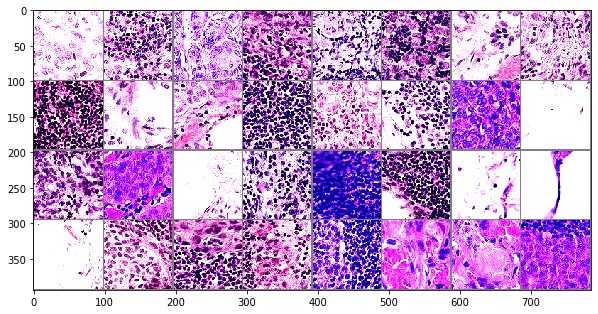

In [0]:
classes = ['b0','m0']

# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Resnet Architecture

### Importing the Architecture

In [0]:
from torch import nn
MODEL_NAME == "DenseNet121"
num_classes = 2

if MODEL_NAME == "DenseNet121"
  net = torchvision.models.densenet121(pretrained = True)
  # We replace last layer of resnet to match our number of classes which is 2
  net.fc = nn.Linear(2048, num_classes)
  net = net.to(device)

else if MODEL_NAME == "VGG19_bn" 
  net = torchvision.models.vgg19_bn(pretrained = True)
  # We replace last layer of resnet to match our number of classes which is 2
  net.fc = nn.Linear(2048, num_classes)
  net = net.to(device)

else if MODEL_NAME == "resnet18"
  net = torchvision.models.resnet18(pretrained = True)
  # We replace last layer of resnet to match our number of classes which is 2
  net.fc = nn.Linear(512, num_classes)
  net = net.to(device)

else if MODEL_NAME == "mobilenet_v2"
  net = torchvision.models.mobilenet_v2(pretrained = True)
  # We replace last layer of resnet to match our number of classes which is 2
  net.fc = nn.Linear(2048, num_classes)
  net = net.to(device)  

### Metrics and Validation Evaluation

In [0]:
from sklearn.metrics import accuracy_score
!mkdir checkpoints

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), MODEL_NAME+'.pt')
        self.val_loss_min = val_loss    

mkdir: cannot create directory ‘checkpoints’: File exists


### Training Progress

In [0]:
from barbar import Bar
import torch.optim as optim


load_checkpoint = False

## Optimizer and Loss Configurations

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 7)

#optimizer = optim.Adadelta(net.parameters())

if load_checkpoint == True:
  net.load_state_dict(torch.load(MODEL_NAME+'.pt'))

patience_es = 11
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience_es, verbose=True)
# number of loops over the dataset
num_epochs = 60
accuracy = []
val_accuracy = []
losses = []
val_losses = []
best_accuracy = 0


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(Bar(train_data_loader)):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    scheduler.step(val_loss)

    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
    early_stopping(val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


print('Finished Training')
training_metrics=np.transpose([losses,accuracy,val_losses,val_accuracy])

fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(training_metrics[:,[0,2]])
plt.legend(["training","validation_training"])
plt.title('Training Loss') 
fig.add_subplot(1, 2, 2)
plt.plot(training_metrics[:,[1,3]])
plt.legend(["training","validation_training"])
plt.title('Training Accuracy') 
plt.show()
# Loading the best model
#net.load_state_dict(torch.load('checkpoint.pt'))

26216/26216: [===============================>] - ETA 0.1s
Epoch: 1
Loss: 0.455  Accuracy:0.808
Validation Loss: 0.437  Val Accuracy: 0.807
Validation loss decreased (inf --> 0.437027).  Saving model ...
26216/26216: [===============================>] - ETA 0.1s
Epoch: 2
Loss: 0.354  Accuracy:0.845
Validation Loss: 0.402  Val Accuracy: 0.817
Validation loss decreased (0.437027 --> 0.401604).  Saving model ...
26216/26216: [===============================>] - ETA 0.1s
Epoch: 3
Loss: 0.323  Accuracy:0.861
Validation Loss: 0.393  Val Accuracy: 0.821
Validation loss decreased (0.401604 --> 0.392838).  Saving model ...
26216/26216: [===============================>] - ETA 0.1s
Epoch: 4
Loss: 0.300  Accuracy:0.873
Validation Loss: 0.407  Val Accuracy: 0.809
EarlyStopping counter: 1 out of 11
26216/26216: [===============================>] - ETA 0.1s
Epoch: 5
Loss: 0.287  Accuracy:0.879
Validation Loss: 0.396  Val Accuracy: 0.817
EarlyStopping counter: 2 out of 11
26216/26216: [==============

In [0]:
MODEL_NAME

'VGG19_bn'

In [0]:
testing_images = os.listdir("test")
testing_images = sorted( testing_images, key=lambda a: int((a.split("Image")[-1]).split(".")[0]) )

!pip install xlsxwriter
import xlsxwriter

# Create an new Excel file and add a worksheet.
workbook = xlsxwriter.Workbook('test_results.xlsx')
worksheet = workbook.add_worksheet()

# Loading the model 
net.load_state_dict(torch.load('resnet18.pt'))


count = 0
from PIL import Image
for i in range(len(testing_images)):
  im = Image.open(os.path.join("test",testing_images[i]))

  #1
  #test = transforms.Resize((224,224))
  #image = test(im)

  #2 
  test = transforms.ToTensor()
  image = test(im)

  #3 
  test = transforms.Normalize(norm_mean, norm_std)
  image = test(image)

  #4
  image = image.unsqueeze(0)
  #print(image.shape)

  # Making the Prediction
  image = image.to(device)
  net.eval()

  #Assigning the label
  outputs = net(image)
  _, predicted = torch.max(outputs.data, 1)

  ####### Doing this to convert Nevi into Lesion and Lesion into Nevi 
  predicted = abs(predicted)
  ###################################################################
  
  worksheet.write(count, 0, predicted)
  count= count + 1


workbook.close()

### Testing

In [0]:
net.load_state_dict(torch.load('checkpoints/checkpointVGG19.pt'))

correct = 0
total = 0
net.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

NameError: ignored